# Setup of File

The following are done in this section:

*   Mount Drive
*   Download/Import Libraries
*   Activate Environment
*   Locate Working Dir and Dataset Files

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# personal
# %cd gdrive/My\ Drive/NLP_HW1/nlp2020-hw1/hw1/stud 

%cd gdrive/My\ Drive/nlp2020-hw1/hw1/stud
!ls
  

/content/gdrive/.shortcut-targets-by-id/1QcOyZ4M-V21hM1AQD_BOlsVRd3FVVVUA/NLP_HW1/nlp2020-hw1/hw1/stud
babelnet2wordnet.tsv  LocOrg_samples.txt
images		      Loc_samples.txt
implementation.py     Org_samples.txt
__init__.py	      trainer_3_withoutPreTrainedEmbed.ipynb


In [3]:
# Setup Client and activate new environment 

# !source activate nlp2020-hw1
import sys
!{sys.executable} -m pip install conllu

In [4]:
# !source activate nlp2020-hw1
import os, pickle
import numpy as np
import itertools
from conllu import parse 
import torch
from tqdm import tqdm
from collections import Counter
from collections import defaultdict 
from torch.utils.data import DataLoader
from gensim.models import KeyedVectors

# For plotting results:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix as multi_cm


# Get path for each file type
directory = os.getcwd() 
dataset_dir = os.path.join(directory, "..", "..", "data")
model_dir = os.path.join(directory, "..", "..", "model")

file_train = os.path.join(dataset_dir, "train.tsv")
file_dev = os.path.join(dataset_dir, "dev.tsv")
file_test = os.path.join(dataset_dir, "test.tsv")
embed_file = os.path.join(model_dir, "embeddings.vec")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preparation

The following are done in this section:

*   Load Pre-Trained word2vec gensim model, which used Sense Tagged data to train
*   Create the Vocab class to create the vocabularies
*   Create the NERTaggingData class to create an encoded Dataset
*   Get the NER tagged datasets
*   Build vocabulary for text and labels --> corresponding indices
*   Encode the each sample in the NER tagged datasets ]with its corresponding indices given by the vocabs
*   Update the NER tagged datasets to load with the batch size 

In [0]:
class Vocab:
    def __init__(self, counter, special_tokens, min_freq=1):

        # Initiate dictionary and reverse dictionary
        self.str2int = defaultdict()
        # self.int2str = dict()
        self.int2str = list()
        self.special_tokens = special_tokens
        
        # Add special tokens first to the dictionary
        if len(special_tokens) > 0:
            for i, word in enumerate(special_tokens):
                self.str2int[word] = i
                # self.int2str[i] = word 
                self.int2str.append(word)
                
                # Set the variable unk_index
                if word == '<unk>':
                    self.unk_index = i
            
        
        # Add tokens form/label to the dictionaries that have a minimum frequency
        counting = 0 + len(special_tokens)
        for i, word in enumerate(counter):
            if counter[word] >= min_freq:
                self.str2int[word] = counting
                # self.int2str[i + len(special_tokens)] = word 
                self.int2str.append(word)
                counting += 1

      
        
    def __len__(self):
          return len(self.str2int)

    # Used to get an item from the dictionaries 
    def __getitem__(self, key):
        if isinstance(key, int):
            try:
                item = self.int2str[key]
            except:
                # If out of range, will suggest another value within and return None for the item
                item = print('Key index is out of range. Please choose an integer value between 0 and', len(self.str2int))

            
        if isinstance(key, str):
            try:
                item = self.str2int[key]
            except:
                # If string key is not in the dictionary, will return index for UNK - unknown
                item = self.str2int['<unk>']            
            
            
        return item

    # Similar to the variable used in TorchText Vocab, does it above much simpler without needing to call this variable
    def str2int(self):
        def __getitem__(self, key):
            try:
                item = self.str2int[key]
            except:
                item = self.str2int['<unk>']         
        return item

    # Similar to the variable used in TorchText Vocab, does it above much simpler without needing to call this variable
    def int2str(self):
        def __getitem__(self, key):
            try:
                item = self.int2str[key]
            except:
                item = print('Key index is out of range. Please choose an integer value between 0 and', len(self.str2int))
        return item

    # Load the pre-trained vectors into the dictionary. The previous vocab and
    # these vectors will have to be aligned to update the integers -> vectors,
    # add any missing words, and make 'unk' those words that aren't in the vectors
    def load_vectors(self, trained_model):
        # Add special tokens first to the dictionary
        if len(self.special_tokens) > 0:
            if '<unk>' in self.special_tokens: 
                w2v_model.add('<unk>', np.positive(w2v_model.get_vector('a')*0), replace=False)

            for i, word in enumerate(self.special_tokens):
                # add special tokens to the word2vec model
                change = 0.00001 * i
                if word != '<unk>': w2v_model.add(word, np.positive(w2v_model.get_vector('<unk>'))+change,replace=False)

        vocab_embed = list((w2v_model.vocab).keys())

        return vocab_embed, w2v_model


In [0]:
class NERTaggingData:

    def __init__(self, 
                 data_file:str, 
                 window_size:int, 
                 window_shift:int=-1,
                 lowercase=True, 
                #  device="cpu"):
                 device="cuda"):
        """
        Args:
            data_file: The path to the dataset already tokenized to be loaded.
            
            window_size:  The maximum number of tokens in a sentence.
            
            window_shift: The number of tokens to shift the window in the
                          sentence. Default value is -1: window will be 
                          shifted by window_size.
            
            lowercase:  Whether the text has to be lowercased or not. For embeddings
                        with uppercase words, uppercase is useful (put as False)
            
            device:  device to run tensors (cpu or cuda).
            
        Output:
            encoded_data: List of samples with each token and its NER tag
        """

        self.data_file = data_file
        self.window_size = window_size
        self.window_shift = window_shift if window_shift > 0 else window_size
        # read and parse entire data file
        with open(data_file) as reader:
            sentences = parse(reader.read())

        # lowers each token, if envoked
        self.lowercase = lowercase
        if self.lowercase:
            for item in itertools.chain.from_iterable(sentences):
                item["form"] = item["form"].lower()
        
        # In case to test with only lowercase first word in sentence
        # else:
        #     for item in itertools.chain.from_iterable(sentences):
        #         if item['id'] == 0:
        #             continue
                    # item["form"] = item["form"].lower()

        self.device = device
        self.data = self.divide_windows(sentences)
        self.encoded_data = None

    # Get the length of the data
    def __len__(self):
        return len(self.data)

    # Returns a sample from the encoded dataset given an index
    def __getitem__(self, idx):
        if self.encoded_data is None:
            raise RuntimeError("""Have to call 'encode_dataset' on this object
            before trying to retrieve elements. In case you want to retrieve raw
            elements, use the method get_windowItem(idx)""")
        return self.encoded_data[idx]


    # Returns a item widonw in the original data structure (without encoding)
    def get_windowItem(self, idx):
        return self.data[idx]


    def divide_windows(self, sentences):
        """ 
        Args:
            sentences:  list of lists of dictionaries (each represents a parsed word occurrence)

        Output:
            data: data that is divided in equal amounts of tokens for each sentence.
                  based on windows size and shift. If extra tokens, an empty None
                  pad is added.
        """
        data = []
        for sentence in sentences:
            for i in range(0, len(sentence), self.window_shift):
                win_size = len(sentence)-i
                if win_size >= self.window_size: window = sentence[i:i+self.window_size]
                else: window = sentence[i:i+self.window_size] + [None]*(self.window_size - win_size)
                data.append(window)
        return data

 
    def encode_dataset(self, vocabulary, label_vocabulary):
       """ 
        Args:
            vocabulary: vocabulary with mappings from words to indices and viceversa

            label_vocabulary: vocabulary with mappings from a string label 
                                to its corresponding index and vice versa

        Output:
            encoded_data: data encoded into inputs and outputs for each window.
                          For windows with None items, a pad is added to its label.
        """
        self.encoded_data = list()
        for i in range(len(self.data)):
            window = self.data[i]
            # text/label encoded are created by calling static cuntions in this class
            # device = torch.device(self.device if torch.cuda.is_available() else "cpu")
            encoded_text = torch.LongTensor(self.get_encode_text2index(window, vocabulary)).to(self.device)
            encoded_labels = torch.LongTensor(self.get_encode_label(window, label_vocabulary)).to(self.device)

            self.encoded_data.append({"inputs":encoded_text, 
                                      "outputs":encoded_labels})


    @staticmethod
    # Get the encoded label for each item in the from of a dictionary in the window
    # If the item is None, the label becomes <pad>
    def get_encode_label(window:list, 
                         l_label_vocabulary:Vocab):
        label_out = list()
        for item_dic in window:
            if item_dic is not None: 
                label_out.append(l_label_vocabulary[item_dic["lemma"]])
            else: 
                label_out.append(l_label_vocabulary["<pad>"])
        return label_out

    @staticmethod
    # Get the encoded index of the text for each item in the from of a dictionary in the window
    # If the item is None, the label becomes <pad>
    def get_encode_text2index(window:list, 
                              l_vocabulary:Vocab):
        indices = list()
        for item_dic in window:
            if item_dic is None: 
                indices.append(l_vocabulary.str2int["<pad>"])
            # if word exists in vocabulary after converting the word string to integer
            elif item_dic["form"] in l_vocabulary.str2int: 
                indices.append(l_vocabulary.str2int[item_dic["form"]])
            # if word doesn't exist in vocabulary, add UNK indices for unknown
            else: indices.append(l_vocabulary.unk_index) 
                
        return indices


    @staticmethod
    # Get a list of the decoded text from the output of NN model in the from of a tensor
    def get_decode_index2text(model_outputs, label_vocabulary):
        """
        Args:
            model_output:   a Tensor with shape (batch_size, max_len, label_vocab_size)
                            containing the output of the neural network model.

            label_vocabulary: vocabulary with mappings from a string label 
                                to its corresponding index and vice versa

        Output:
            The method returns a list of batch_size length where each element is a list
            of labels, one for each input token.
        """        

        max_indices = torch.argmax(model_outputs, -1).tolist() 
        predictions = list()

        # get word text in vocabulary after converting the index integer to word string
        for indices in max_indices:
            predictions.append([label_vocabulary.int2str(i) for i in indices])

        return predictions



In [0]:
# Build a vocabulary for each word and label found as a token dictionary
def build_vocab(dataset, w2v_model, min_freq=1):
    counter_vocab = Counter()
    counter_label = Counter()

    for i in tqdm(range(len(dataset))):
        for token in dataset.get_windowItem(i):
            if token is not None:
                counter_vocab[token["form"]] += 1
                counter_label[token["lemma"]] += 1
    
    # Special tokens added for padding and unknown words at testing time
    vocabulary = Vocab(counter_vocab, special_tokens=['<pad>', '<unk>'], min_freq=min_freq)
    print('Vocabulary length is:  ', len(vocabulary))
    if w2v_model != None:
        vocab_embed, w2v_model = vocabulary.load_vectors(w2v_model)
        print('Updated embedding with the special tokens.')

    label_vocabulary = Vocab(counter_label, special_tokens=['<pad>'])

    return vocabulary, label_vocabulary, vocab_embed, w2v_model

In [11]:
window_size, window_shift = 100, 100

# Get the NER tagged datasets
train_dataset = NERTaggingData(file_train, window_size, window_shift, lowercase=False)
dev_dataset = NERTaggingData(file_dev, window_size, window_shift, lowercase=False)
test_dataset = NERTaggingData(file_test, window_size, window_shift, lowercase=False)



nameFiles = ["vocabulary.pkl", "label_vocabulary.pkl", "pretrained_embed.pkl"]
savedFiles = [idx for idx in os.listdir(model_dir) if idx.endswith('.pkl')]

if all(elem in savedFiles  for elem in nameFiles): 
    embed_dim = 400

    # Load vocabulary
    with open(os.path.join(model_dir, "vocabulary.pkl"),"rb") as file:  
        vocabulary = pickle.load(file)

    with open(os.path.join(model_dir, "label_vocabulary.pkl"),"rb") as file:  
        label_vocabulary = pickle.load(file)

    # Get pre-trained embedings
    with open(os.path.join(model_dir, "pretrained_embed.pkl"),"rb") as file:  
        pretrained_embed = pickle.load(file)

else:

    # Load the word2vec model that has been pre-trained, and get its vocabulary
    # Get the weights of the embeddings to use later in the NER tag model
    w2v_model = KeyedVectors.load_word2vec_format(embed_file, binary = False)
    vocab_embed = list((w2v_model.vocab).keys())
    embed_dim = w2v_model.vector_size

    # Build vocabulary for text and labels --> corresponding indices
    vocabulary, label_vocabulary, vocab_embed, w2v_model = build_vocab(train_dataset, w2v_model, min_freq=1)

    # Get pre-trained embedings
    pretrained_embed = torch.randn(len(vocabulary), embed_dim)
    initialized = 0
    for i, word in enumerate(vocabulary.int2str):
        if word in vocab_embed:
            initialized += 1
            pretrained_embed[i] = torch.from_numpy(w2v_model[word].copy())
    print('Amount of initialized pre-trained embedings are: ', initialized)

    # Save the vocabularies
    with open(os.path.join(model_dir,"vocabulary.pkl"),"wb+") as file:  
        pickle.dump(vocabulary, file)

    with open(os.path.join(model_dir,"label_vocabulary.pkl"),"wb+") as file:  
        pickle.dump(label_vocabulary, file)

    with open(os.path.join(model_dir,"pretrained_embed.pkl"),"wb+") as file:  
        pickle.dump(pretrained_embed, file)

    print('Items saved..')

    del w2v_model, vocab_embed



# Encode the dataset each sample with its corresponding indices given by the vocabs
train_dataset.encode_dataset(vocabulary, label_vocabulary)
dev_dataset.encode_dataset(vocabulary, label_vocabulary)
test_dataset.encode_dataset(vocabulary, label_vocabulary)

# Update the datasets to include the batch size 
train_dataset = DataLoader(train_dataset, batch_size=128)
dev_dataset = DataLoader(dev_dataset, batch_size=128)
test_dataset = DataLoader(test_dataset, batch_size=128)



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
100%|██████████| 100042/100042 [00:02<00:00, 38908.79it/s]


Vocabulary length is:   100843
Updated embedding with the special tokens.
Amount of initialized pre-trained embedings are:  22246


/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Items saved..


In [0]:
torch.cuda.empty_cache()

In [16]:
print("car index: ", vocabulary["car"])
print("<pad> index: ", vocabulary["<pad>"])
print("<unk> index", vocabulary["<unk>"])
print("word at index 154: ", vocabulary.int2str[154])
print("unknown words are indexed at: ", vocabulary["dskvas"])

car index:  5838
<pad> index:  0
<unk> index 1
word at index 154:  largest
unknown words are indexed at:  1


# Model Building

The following is included in this section:

*   Define the Hyperparameter Class
*   Create the NER Model Class
*   Create the Trainer Class



In [0]:
class HypParams():
    def __init__(self, vocabulary, label_vocabulary, embed_dim, embeddings=None):
        self.vocabulary = vocabulary
        self.label_vocabulary = label_vocabulary
        self.vocab_size = len(self.vocabulary)
        self.hidden_dim = 64
        self.embedding_dim = embed_dim
        self.num_classes = len(self.label_vocabulary) 
        self.bidirectional = True
        self.num_layers = 2
        self.dropout = 0.5
        self.embeddings = embeddings
model_param = HypParams(vocabulary, label_vocabulary, embed_dim, pretrained_embed)

In [0]:
class NER_Model(torch.nn.Module):

    def __init__(self, model_param):
        super(NER_Model, self).__init__()

        # Embedding layer: a matrix (shape: vocab_size, embedding_dim). Where 
        # each index represents a word
        self.word_embedding = torch.nn.Embedding(model_param.vocab_size, 
                                                 model_param.embedding_dim) #,

        if model_param.embeddings is not None:
            print("Initializing embeddings layer from Pre-trained Sense Embeddings..")
            self.word_embedding.weight.data.copy_(model_param.embeddings)

        # Bi-LSTM 
        self.lstm = torch.nn.LSTM(input_size = model_param.embedding_dim, 
                                  num_layers = model_param.num_layers,
                                  hidden_size = model_param.hidden_dim,                                    
                                  dropout = model_param.dropout,
                                  bidirectional = model_param.bidirectional)
        
        lstm_output_dim = model_param.hidden_dim * 2

        self.dropout = torch.nn.Dropout(model_param.dropout)
        # fully connected layer
        self.classifier = torch.nn.Linear(lstm_output_dim, model_param.num_classes)

    def forward(self, x):
        embeddings = self.word_embedding(x)
        embeddings = self.dropout(embeddings)
        o, (h, c) = self.lstm(embeddings)
        o = self.dropout(o)
        output = self.classifier(o)
        
        return output

In [20]:
nertag_Model = NER_Model(model_param).cuda()
nertag_Model

Initializing embeddings layer from Pre-trained Word Embeddings..


NER_Model(
  (word_embedding): Embedding(100843, 400)
  (lstm): LSTM(400, 64, num_layers=2, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=128, out_features=5, bias=True)
)

In [0]:
class Trainer:
  
    def __init__(self, model, loss_function, optimizer, label_vocab):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.label_vocab = label_vocab

    def train(self, train_dataset, valid_dataset, epochs:int=2):

        print('Training ...')
        train_loss = 0.0
        for epoch in range(epochs):
            print(' Epoch {:03d}'.format(epoch + 1))

            epoch_loss = 0.0
            self.model.train()

            for step, item in enumerate(train_dataset):
                inputs = item['inputs']
                labels = item['outputs']
                self.optimizer.zero_grad()

                #input data to model to train and output the prediction
                pred = self.model(inputs)
                pred = pred.view(-1, pred.shape[-1])
                labels = labels.view(-1)
                
                loss = self.loss_function(pred, labels)
                loss.backward(create_graph=True)
                self.optimizer.step()

                epoch_loss += loss.tolist()
                
                # if step % 500 == 0:
                #     print('\tStep {}: current loss = {:0.4f}'.format(step, epoch_loss / (step + 1)))
            
            avg_epoch_loss = epoch_loss / len(train_dataset)
            train_loss += avg_epoch_loss
            
            print('\tAverage Train loss = {:0.4f}'.format(avg_epoch_loss))

        print('Done Training!')
        avg_epoch_loss = train_loss / epochs
        
        return avg_epoch_loss


In [23]:
trainer = Trainer(
    model = nertag_Model,
    loss_function = torch.nn.CrossEntropyLoss(ignore_index=label_vocabulary['<pad>']),
    optimizer = torch.optim.Adam(nertag_Model.parameters()),
    label_vocab=label_vocabulary)

trainer.train(train_dataset, dev_dataset, 20)

Training ...
 Epoch 001
	Train loss = 0.3064
 Epoch 002
	Train loss = 0.2152
 Epoch 003
	Train loss = 0.1848
 Epoch 004
	Train loss = 0.1662
 Epoch 005
	Train loss = 0.1534
 Epoch 006
	Train loss = 0.1436
 Epoch 007
	Train loss = 0.1359
 Epoch 008
	Train loss = 0.1295
 Epoch 009
	Train loss = 0.1240
 Epoch 010
	Train loss = 0.1198
 Epoch 011
	Train loss = 0.1157
 Epoch 012
	Train loss = 0.1121
 Epoch 013
	Train loss = 0.1090
 Epoch 014
	Train loss = 0.1064
 Epoch 015
	Train loss = 0.1042
 Epoch 016
	Train loss = 0.1019
 Epoch 017
	Train loss = 0.0999
 Epoch 018
	Train loss = 0.0981
 Epoch 019
	Train loss = 0.0967
 Epoch 020
	Train loss = 0.0950
... Done!


0.13589817705156898

In [0]:
# Save model weights
model_name = '05_capTot_embed_Bi-LSTM'
saved_model_path = os.path.join(model_dir, model_name + ".pt")
output = open(saved_model_path, mode="wb+")
torch.save(nertag_Model.state_dict(), output)
output.close()

In [0]:
# Computes the performance of the model for different datasets needed
def compute_performance(model, #:torch.nn.Module, 
                        dataset, #:DataLoader, 
                        label_vocab): #:Vocab):
    predictions = list()
    labels = list()

    model.eval()

    with torch.no_grad():
        for item in dataset:
            inputs = item["inputs"]
            outputs = item["outputs"].tolist()

            prediction = model(inputs)
            prediction = torch.argmax(prediction, -1).tolist() 

            for i, item in enumerate(outputs):
                max_index = len(item) - item.count(0)
                labels += item[:max_index]
                predictions += prediction[i][:max_index]
                # print(prediction[i][:max_index])
                # print(item[:max_index], '\n')


    # macro precision, recall, f1: computes metric and then averages across class.  
    # Doesn't take into account the quantity of samples per class
    macro_precision = precision_score(labels, predictions, average="macro", zero_division=0)
    macro_recall = recall_score(labels, predictions, average="macro", zero_division=0)
    macro_f1 = f1_score(labels, predictions, average="macro", zero_division=0)

    # To check the precision per class
    per_class_f1 = f1_score(labels, predictions, labels = list(i for i, item in enumerate(label_vocabulary.str2int)), average=None, zero_division=0)

    # Confusion matrix
    confusionMatrix = confusion_matrix(labels, predictions, labels = [i for i in label_vocabulary.str2int.values()][1:], normalize='true')
    # confusionMatrix = multi_cm(labels, predictions, labels = [i for i in label_vocabulary.str2int.values()][1:]) # to compare two classes together at a time



    output_performance = {"macro_precision":macro_precision,
                          "macro_recall":macro_recall, 
                          "macro_f1":macro_f1,
                          "per_class_f1":per_class_f1,
                          "confusionMatrix":confusionMatrix}

    return output_performance


In [26]:
# Gets the performance for train, dev, and testing
# Then, plots a table with recall, precision and f1 (overall and per class) 

performance_train = compute_performance(nertag_Model, train_dataset, label_vocabulary)
performance_dev = compute_performance(nertag_Model, dev_dataset, label_vocabulary)
performance_test = compute_performance(nertag_Model, test_dataset, label_vocabulary)

# Overall Precision, Recall and F1
print("Performance Type\tTrain\t\tValidation\tTest")
print("="*65)
print("Precision:\t\t{:0.3f}\t\t{:0.3f}\t\t{:0.3f}".format(performance_train["macro_precision"], performance_dev["macro_precision"], performance_test["macro_precision"]))
print("Recall:\t\t\t{:0.3f}\t\t{:0.3f}\t\t{:0.3f}".format(performance_train["macro_recall"], performance_dev["macro_recall"], performance_test["macro_recall"]))
print("F1:\t\t\t{:0.3f}\t\t{:0.3f}\t\t{:0.3f}".format(performance_train["macro_f1"], performance_dev["macro_f1"], performance_test["macro_f1"]))
print("-"*65)
print('F1 per Class')

# Per Class F1
train_perClass = list()
dev_perClass = list()
test_perClass = list()
#train
for id_class, performance in sorted(enumerate(performance_train["per_class_f1"]), key=lambda elem: -elem[1]):
    label = label_vocabulary.int2str[id_class]
    train_perClass += [label, performance]
#dev
for id_class, performance in sorted(enumerate(performance_dev["per_class_f1"]), key=lambda elem: -elem[1]):
    label = label_vocabulary.int2str[id_class]
    dev_perClass += [label, performance]
#test
for id_class, performance in sorted(enumerate(performance_test["per_class_f1"]), key=lambda elem: -elem[1]):
    label = label_vocabulary.int2str[id_class]
    test_perClass += [label, performance]

# Place results of per Class in table
labels = ['O', 'PER', 'LOC', 'ORG']
for item in labels:
    print("\t{}:\t\t{:0.3f}\t\t{:0.3f}\t\t{:0.3f}".format(item, train_perClass[train_perClass.index(item)+1], dev_perClass[dev_perClass.index(item)+1], test_perClass[test_perClass.index(item)+1]))



Performance Type	Train		Validation	Test
Precision:		0.876		0.825		0.834
Recall:			0.847		0.782		0.788
F1:			0.858		0.799		0.806
-----------------------------------------------------------------
F1 per Class
	O:		0.991		0.985		0.985
	PER:		0.919		0.824		0.831
	LOC:		0.822		0.755		0.771
	ORG:		0.700		0.631		0.636


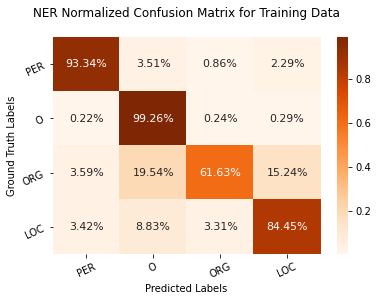

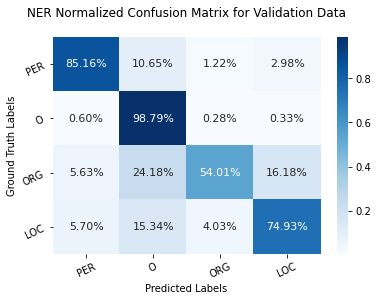

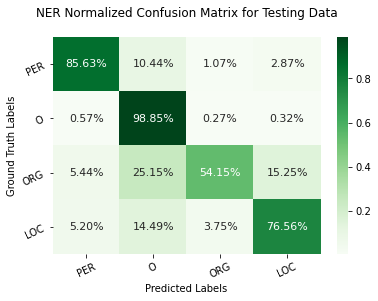

In [27]:
# Plots a heat map confusion matrix for each train, dev, test

# Confusion Matrix for TRAINING
df_confusionMatrix = pd.DataFrame(performance_train["confusionMatrix"], index = [i for i in label_vocabulary.int2str[1:]],
                  columns = [i for i in label_vocabulary.int2str[1:]])
ax = plt.axes()
sn.heatmap(df_confusionMatrix, annot=True, annot_kws={"size": 11}, cmap='Oranges', ax = ax, fmt='.2%')
ax.set_title('NER Normalized Confusion Matrix for Training Data', pad=20)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Ground Truth Labels')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 25, fontsize = 10)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)
plt.savefig('images/CM_train.png', bbox_inches='tight', pad_inches=0.2)
plt.show()

# Confusion Matrix for VALIDATION
df_confusionMatrix = pd.DataFrame(performance_dev["confusionMatrix"], index = [i for i in label_vocabulary.int2str[1:]],
                  columns = [i for i in label_vocabulary.int2str[1:]])
ax = plt.axes()
sn.heatmap(df_confusionMatrix, annot=True, annot_kws={"size": 11}, cmap='Blues', ax = ax, fmt='.2%')
ax.set_title('NER Normalized Confusion Matrix for Validation Data', pad=20)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Ground Truth Labels')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 25, fontsize = 10)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)
plt.savefig('images/CM_dev.png', bbox_inches='tight', pad_inches=0.2)
plt.show()

# Confusion Matrix for TESTING
df_confusionMatrix = pd.DataFrame(performance_test["confusionMatrix"], index = [i for i in label_vocabulary.int2str[1:]],
                  columns = [i for i in label_vocabulary.int2str[1:]])
ax = plt.axes()
sn.heatmap(df_confusionMatrix, annot=True, annot_kws={"size": 11}, cmap='Greens', ax = ax, fmt='.2%')
ax.set_title('NER Normalized Confusion Matrix for Testing Data', pad=20)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Ground Truth Labels')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 25, fontsize = 10)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)
plt.savefig('images/CM_test.png', bbox_inches='tight', pad_inches=0.2)
plt.show()

In [28]:
from sklearn.manifold import TSNE

# plots a 2D vector of the multidimensional (400) trained POS embeddings
def plot_embed(w2v_model):
    labels, tokens = list(), list()
    x, y = list(), list() 
    # transform only 2000 words excluding unk and pad
    vocab_embed = list((w2v_model.vocab).keys())[2:2_000] 

    for word in vocab_embed:
        tokens.append(w2v_model[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=1000, random_state=3)
    transformed_items = tsne_model.fit_transform(tokens)
    print('Model for plotting Embeddings in 2D, was created, fitted, and transformed!')

    for item in transformed_items[100:200]:
        x.append(item[0])
        y.append(item[1])
        
    # To plot only 100 words
    x = x[300:400]
    y = y[300:400]

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig('images/POSembed_vector.png', bbox_inches='tight', pad_inches=0.2)
    plt.show()

w2v_model = KeyedVectors.load_word2vec_format(embed_file, binary = False)
plot_embed(w2v_model)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Model for plotting Embeddings in 2D, was created, fitted, and transformed!


<Figure size 1152x1152 with 0 Axes>